In [8]:
import matplotlib.pyplot as plt
from matplotlib.ticker import Formatter    # to convert xaxis label to dates
from datetime import datetime, timedelta
import pytz
import pandas as pd
import datetime
from datetime import date
import time
import numpy as np
import copy



from lz_ignition_dbi.lz_ignition_dbi import IDBIWrapper
import lz_ignition_dbi.lz_ignition_bindata as bindata

#starting from here:
#https://gitlab.com/luxzeplin/sharing/slowcontrolanalysis/-/blob/main/DetectorStatusChecks.ipynb

In [9]:
tags  = ['5505OHM', '5502DO', 'S1ODROW1', 'S1ODROW2', 'S1ODROW3', 'S1ODROW4', 'S1ODROW5', 'S1ODROW6']
days_past=60


In [10]:
axis_type = 'dateLabel' 
TIMEZONE = 'US/Mountain'
DATEFORMAT = '%Y-%-m-%-dT%H:%M'  # see https://strftime.org/

class DateFormat(Formatter):
    """
    This class converts the seconds since unix epoch to date strings
    """
    def __init__(self, format=None, timezone=None):
        self.format = format if format is not None else '%Y-%m-%dT%H:%M'
        self.timezone = timezone if timezone is not None else 'US/Mountain'

    def __call__(self, x, pos=None):
        tz = pytz.timezone(TIMEZONE)
        newticklabel = datetime.datetime.fromtimestamp(x).astimezone(tz).strftime(self.format)
        return newticklabel

dateformatter = DateFormat(DATEFORMAT, TIMEZONE)

In [15]:
# Retrieve the slow control data from the Ignition DB, '2021-12-23T09:30:00' start of SR1

end = datetime.datetime.fromtimestamp(time.time()) # Get today's date
start = end - datetime.timedelta(days=days_past)           # Get date from a week ago
print(start)
print(end)
end = end.isoformat()                              # Convert to correct format
start = start.isoformat()
#start='2022-11-27 00:00:00'
#end='2022-12-12 00:00:00'
start='2022-11-30 00:00:00'
end='2022-12-05 00:00:00'


idbi = IDBIWrapper(known_tags_file='/global/u2/p/penning/work/od_ignition_mon/bp_tag_map_PMTs.json')
idbi.select(tags, start, end)
data = idbi.resolve(dateformat='unix')

# DBI returns times in units of ms. Convert to s for formatter
for t in tags:
    data[t]['times'] = [ x/1000. for x in data[t]['times'] ]  

2022-12-11 19:32:15.211162
2023-02-09 19:32:15.211162


KeyError: 'excess_cond'

In [ ]:
fig = plt.figure()
def plotIgnition(dataf, fname,ylabel,ax=None,options='', ylim=[]):
    if ax is None:
        ax = plt.gca()
    ax.plot(dataf[fname]['times'], dataf[fname]['vals'], options, label=fname)
    plt.ylabel(ylabel)
    if ylim:
        ax.set_ylim(ylim)
    ax.legend(frameon=False)
    # Convert UNIX timestamps to human-readable
    ax.xaxis.set_major_formatter(dateformatter)
    # Rotate the tick labels and align them to the right
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment('right')
        tick.set_rotation(15)
    fig.subplots_adjust(bottom=0.2, left=0.15)
    return ax

In [16]:
temp = copy.deepcopy(data)


#print(excess_cond.keys())
#print(excess_cond['5505OHM'].keys())
#print(excess_cond['5505OHM']['vals'][0:5])
#for v in excess_cond['5505OHM']['vals'][0:5]:
#        print(v)

new_dict = {'excess_cond':{'vals':[], 'times':[]}, 
            'cond_ratio':{'vals':[], 'times':[]},
            '5505OHM':{'vals':[], 'times':[]}
           }

i=0
#for v in temp['5505OHM']['vals'][0:len(temp['S1ODROW6']['vals'])]:
for v in temp['5505OHM']['vals']:
        r=temp['5505OHM']['vals'][i]
        rho=((1/r)-(1/18.6))
        new_dict['excess_cond']['vals'].append(rho)
        new_dict['excess_cond']['times'].append(temp['5505OHM']['times'][i])
        
#        new_dict['cond_ratio']['vals'].append(rho/temp['S1ODROW6']['vals'][i])
#        new_dict['cond_ratio']['times'].append(temp['5505OHM']['times'][i])

        i+=1;

#print(temp['5505OHM']['times'][:5])
#print(new_dict['excess_cond']['times'][0:5])
tags=['excess_cond', 'cond_ratio' ]


<AxesSubplot:ylabel='rate'>

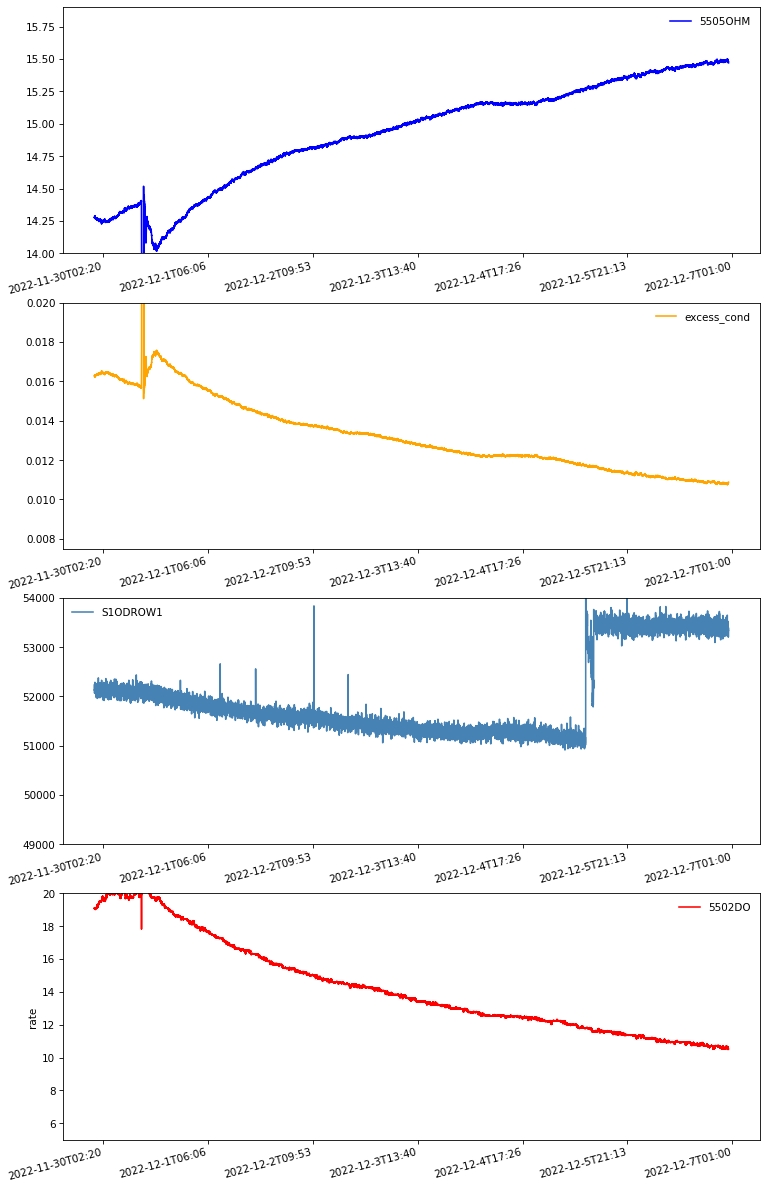

In [22]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=False, figsize=(12,20), dpi=75)
plotIgnition(data,'5505OHM', 'Resistivity [MOhm cm]', ax1, 'b',[14,15.9])
plotIgnition(new_dict, 'excess_cond', 'Excess Cond', ax2,  'orange', [0.0075,2E-2])
plotIgnition(data, 'S1ODROW1', 'rate', ax3,  'steelblue', [49E3, 54E3])
plotIgnition(data, '5502DO', 'rate', ax4,  'red', [5,25])


#plotIgnition(new_dict, 'cond_ratio', 'EC/S1 rate', ax4,  'slateblue',[1E-7,3E-7])
